# TikTok Category Analysis

1. **Hashtag-based categorization**: Group videos by common hashtags
2. **Content-based categorization**: Use NLP on descriptions to infer topics
3. **Engagement pattern categorization**: Cluster videos by engagement behaviors

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('fivethirtyeight')
sns.set(style="whitegrid")

# Load the processed data
df = pd.read_csv('data/processed/tiktok_processed.csv')

print(f"Loaded dataset with {len(df)} videos and {len(df.columns)} features")
df.head()

Loaded dataset with 7225 videos and 47 features


,video_id,author,likes,comments,shares,plays,clean_description,hashtag_list,hashtag_count,create_time,...,has_tag_fyp,has_tag_viral,has_tag_fypシ,has_tag_foryoupage,has_tag_foryou,has_tag_trending,has_tag_relatable,has_tag_funny,has_tag_tiktok,has_tag_fypシviral
0,7506183500660313390,dalebrisby90,44800,125,1863,686000.0,that sounds like jb ima go with truth rodeoti...,"['rodeotime', 'dalebrisby', 'jbmauney']",3,2025-05-19 15:45:53,...,0,0,0,0,0,0,0,0,0,0
1,7507316543605280030,jessicafloriolli,285700,290,963,1200000.0,thanks for sticking around alonzofloriolli,[],0,2025-05-22 17:02:36,...,0,0,0,0,0,0,0,0,0,0
2,7507286333505719582,ay_2fya,38000,65,496,416100.0,publicinterview fyp rizz,"['publicinterview', 'fyp', 'rizz']",3,2025-05-22 15:05:21,...,1,0,0,0,0,0,0,0,0,0
3,7506662216574209310,abell1823,87200,259,23600,725800.0,boat days hit different,[],0,2025-05-20 22:43:34,...,0,0,0,0,0,0,0,0,0,0
4,7506628206280363310,jordanmarielynnxoxo,77600,724,1196,362100.0,a lululemonnnn prettygirl foryoupage trending ...,"['prettygirl', 'foryoupage', 'trending', 'likes']",4,2025-05-20 20:32:12,...,0,0,0,1,0,1,0,0,0,0


## 1. Hashtag-Based Categorization

- Create categories based on the hashtags used in videos 
- This is a natural way to categorize TikTok content as creators often use hashtags to indicate the content type or target audience

In [2]:
# Examine the hashtag_list column
print("Sample hashtag lists:")
for i in range(5):
    if i < len(df):
        print(f"Video {i+1}: {df['hashtag_list'].iloc[i]}")

# Convert string representation of hashtag list back to actual lists if needed
def ensure_list(hashtags):
    if isinstance(hashtags, str):
        try:
            # Handle various string formats
            if hashtags.startswith('[') and hashtags.endswith(']'):
                # Remove brackets and split by commas
                return [tag.strip().strip("'\"") for tag in hashtags[1:-1].split(',')]
            else:
                # Split by spaces or commas
                return [tag.strip() for tag in re.split('[, ]', hashtags) if tag.strip()]
        except:
            return []
    elif isinstance(hashtags, list):
        return hashtags
    else:
        return []

# Apply the function to ensure hashtag_list contains actual lists
df['hashtag_list_clean'] = df['hashtag_list'].apply(ensure_list)

# Count all hashtags to find the most common ones
all_hashtags = []
for tags in df['hashtag_list_clean']:
    if tags:  # Skip empty lists
        all_hashtags.extend(tags)

# Get top hashtags
top_hashtags = Counter(all_hashtags).most_common(30)
print("\nTop 30 hashtags:")
for tag, count in top_hashtags:
    print(f"{tag}: {count}")

Sample hashtag lists:
Video 1: ['rodeotime', 'dalebrisby', 'jbmauney']
Video 2: []
Video 3: ['publicinterview', 'fyp', 'rizz']
Video 4: []
Video 5: ['prettygirl', 'foryoupage', 'trending', 'likes']

Top 30 hashtags:
fyp: 2091
: 2078
viral: 650
fypシ: 458
foryoupage: 441
foryou: 381
trending: 279
relatable: 259
funny: 228
tiktok: 131
fypシviral: 113
xyzbca: 112
streameruniversity: 104
fyppppppppppppppppppppppp: 102
fy: 93
viralvideo: 91
fypage: 91
trend: 87
movie: 80
parati: 78
graduation: 76
real: 75
kaicenat: 75
blowthisup: 63
nba: 58
humor: 56
summer: 50
рекомендации: 50
school: 50
meme: 49


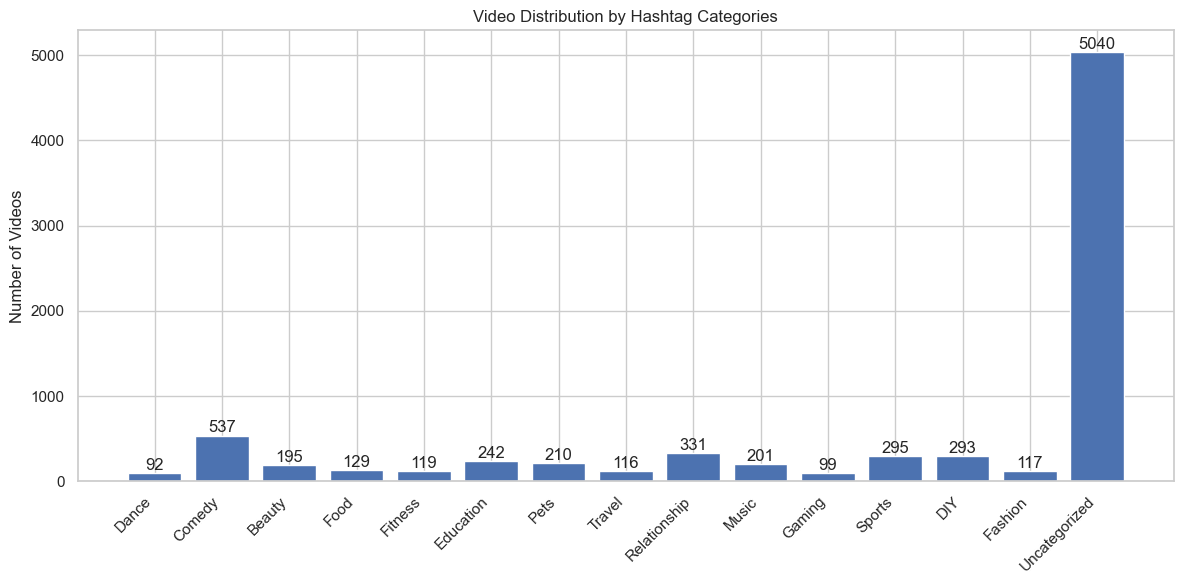


Percentage of videos in each category:
Uncategorized: 69.76%
Comedy: 7.43%
Relationship: 4.58%
Sports: 4.08%
DIY: 4.06%
Education: 3.35%
Pets: 2.91%
Music: 2.78%
Beauty: 2.70%
Food: 1.79%
Fitness: 1.65%
Fashion: 1.62%
Travel: 1.61%
Gaming: 1.37%
Dance: 1.27%


In [3]:
# Create major hashtag categories based on common themes

# Define category mapping based on hashtag keywords
category_keywords = {
    'Dance': ['dance', 'dancer', 'dancing', 'choreography', 'moves', 'routine'],
    'Comedy': ['funny', 'comedy', 'joke', 'humor', 'lol', 'laugh', 'meme', 'comedy'],
    'Beauty': ['makeup', 'beauty', 'skincare', 'hair', 'fashion', 'style', 'outfit'],
    'Food': ['food', 'recipe', 'cooking', 'cook', 'yummy', 'delicious', 'meal', 'baking'],
    'Fitness': ['fitness', 'workout', 'gym', 'exercise', 'health', 'healthy', 'training'],
    'Education': ['learn', 'school', 'college', 'study', 'education', 'howto', 'tips', 'hack'],
    'Pets': ['pet', 'dog', 'cat', 'animal', 'puppy', 'kitten'],
    'Travel': ['travel', 'vacation', 'trip', 'adventure', 'explore', 'wanderlust'],
    'Relationship': ['couple', 'love', 'relationship', 'dating', 'marriage', 'boyfriend', 'girlfriend'],
    'Music': ['music', 'song', 'singer', 'rap', 'musician', 'artist', 'concert'],
    'Gaming': ['game', 'gaming', 'gamer', 'videogame', 'xbox', 'playstation', 'nintendo', 'fortnite'],
    'Sports': ['sport', 'football', 'basketball', 'soccer', 'baseball', 'nba', 'nfl'],
    'DIY': ['diy', 'craft', 'homemade', 'create', 'art', 'project'],
    'Fashion': ['fashion', 'style', 'outfit', 'model', 'clothes', 'clothing', 'dress', 'trendy']
}

# Function to categorize videos based on hashtags
def categorize_by_hashtags(hashtag_list):
    categories = []
    if not hashtag_list:
        return ['Uncategorized']
        
    hashtag_text = ' '.join([str(tag).lower() for tag in hashtag_list])
    
    for category, keywords in category_keywords.items():
        if any(keyword in hashtag_text for keyword in keywords):
            categories.append(category)
    
    return categories if categories else ['Uncategorized']

# Apply categorization
df['hashtag_categories'] = df['hashtag_list_clean'].apply(categorize_by_hashtags)

# Create binary category columns for easier analysis
for category in category_keywords.keys():
    df[f'is_{category.lower()}'] = df['hashtag_categories'].apply(lambda x: 1 if category in x else 0)

# Count videos in each category
category_counts = {}
for category in category_keywords.keys():
    category_counts[category] = df[f'is_{category.lower()}'].sum()
    
# Add uncategorized count
uncategorized_count = sum(1 for cats in df['hashtag_categories'] if 'Uncategorized' in cats)
category_counts['Uncategorized'] = uncategorized_count

# Display category distribution
plt.figure(figsize=(12, 6))
bars = plt.bar(category_counts.keys(), category_counts.values())
plt.xticks(rotation=45, ha='right')
plt.title('Video Distribution by Hashtag Categories')
plt.ylabel('Number of Videos')
plt.tight_layout()

# Add the count numbers on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height}', ha='center', va='bottom')

plt.show()

# Calculate the percentage of videos in each category
total_videos = len(df)
category_percentages = {k: (v/total_videos*100) for k, v in category_counts.items()}

print("\nPercentage of videos in each category:")
for category, percentage in sorted(category_percentages.items(), key=lambda x: x[1], reverse=True):
    print(f"{category}: {percentage:.2f}%")

## 2. Content-Based Categorization using NLP

- Use NLP to analyze video descriptions and identify underlying topics or themes

In [4]:
# Check description data
print("Sample clean descriptions:")
for i in range(5):
    if i < len(df):
        print(f"Video {i+1}: {df['clean_description'].iloc[i][:100]}...")  # Show first 100 chars

# Enhanced description cleaning - remove hashtag-style terms
def clean_description_for_content_analysis(text):
    """Remove hashtag-style terms and social media jargon from description text"""
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase for processing
    text = text.lower()
    
    # Comprehensive list of hashtag-style terms and TikTok-specific jargon to remove
    hashtag_style_terms = {
        # FYP variations
        'fyp', 'foryou', 'foryoupage', 'fypシ', 'fypシviral', 'fypage', 'foru', 'fyr',
        # Viral/trending terms
        'viral', 'trending', 'trend', 'viralvideo', 'viralvideos', 'goingviral',
        # Platform specific
        'tiktok', 'tiktokviral', 'tiktoktrend', 'tiktokdance', 'tiktokfamous',
        # Engagement-seeking terms
        'like', 'likes', 'follow', 'followme', 'subscribe', 'comment', 'share',
        'likeandfollow', 'followforfollow', 'likeforlikes', 'viral_video',
        # Generic social media terms
        'xyzbca', 'explore', 'explorepage', 'discover', 'algorithm',
        # Call-to-action terms
        'duet', 'collab', 'tag', 'mention', 'check', 'link', 'bio',
        # Short meaningless terms
        'lol', 'omg', 'wtf', 'tbh', 'ngl', 'fr', 'periodt', 'oop', 'slay',
        # Description placeholder
        'description', 'desc', 'caption'
    }
    
    # Split into words and filter
    words = text.split()
    filtered_words = []
    
    for word in words:
        word_clean = word.strip()
        
        # Skip if word is in hashtag-style terms
        if word_clean in hashtag_style_terms:
            continue
            
        # Skip very short words (likely abbreviations or noise)
        if len(word_clean) <= 2:
            continue
            
        # Skip words that start with # (remaining hashtags)
        if word_clean.startswith('#'):
            continue
            
        # Skip words that are all numbers
        if word_clean.isdigit():
            continue
            
        # Skip words with excessive repetition (like "looooove")
        if len(set(word_clean)) < len(word_clean) * 0.4 and len(word_clean) > 4:
            continue
            
        # Keep the word if it passes all filters
        filtered_words.append(word_clean)
    
    # Join back and return
    result = ' '.join(filtered_words)
    return result

# Apply enhanced cleaning to create content-focused descriptions
df['content_description'] = df['clean_description'].apply(clean_description_for_content_analysis)

# Filter out rows with missing or empty content descriptions
df_with_desc = df[
    df['content_description'].notna() & 
    (df['content_description'] != '') &
    (df['content_description'].str.len() > 5)  # At least 5 characters for meaningful content
].copy()

print(f"\nFiltered to {len(df_with_desc)} videos with substantial content descriptions")

print("\nSample content descriptions (after removing hashtag-style terms):")
for i in range(5):
    if i < len(df_with_desc):
        idx = df_with_desc.index[i]
        print(f"Video {i+1}:")
        print(f"  Original: {df.loc[idx, 'clean_description']}")
        print(f"  Content-focused: {df_with_desc['content_description'].iloc[i]}")
        print()

# Use TF-IDF to extract important terms from content descriptions only
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    min_df=5,   # Lowered from 10 since we have fewer meaningful terms now
    max_df=0.8  # Ignore terms that appear in more than 80% of documents
)

# Fit the vectorizer on content descriptions only
try:
    tfidf_matrix = tfidf.fit_transform(df_with_desc['content_description'])
    print(f"\nTF-IDF matrix shape: {tfidf_matrix.shape}")
    
    # Top terms by TF-IDF score
    feature_names = tfidf.get_feature_names_out()
    print("\nTop 20 terms by overall TF-IDF importance in content descriptions:")
    term_importance = np.sum(tfidf_matrix, axis=0).A1
    top_term_indices = term_importance.argsort()[-20:][::-1]
    for idx in top_term_indices:
        print(f"{feature_names[idx]}: {term_importance[idx]:.4f}")
except Exception as e:
    print(f"Error in TF-IDF processing: {e}")
    print("Continuing with alternative approach...")

Sample clean descriptions:
Video 1: that sounds like jb ima go with truth  rodeotime dalebrisby jbmauney...
Video 2: thanks for sticking around alonzofloriolli...
Video 3: publicinterview fyp rizz...
Video 4: boat days hit different...
Video 5: a lululemonnnn prettygirl foryoupage trending likes...

Filtered to 6215 videos with substantial content descriptions

Sample content descriptions (after removing hashtag-style terms):
Video 1:
  Original: that sounds like jb ima go with truth  rodeotime dalebrisby jbmauney
  Content-focused: that sounds ima with truth rodeotime dalebrisby jbmauney

Video 2:
  Original: thanks for sticking around alonzofloriolli
  Content-focused: thanks for sticking around alonzofloriolli

Video 3:
  Original: publicinterview fyp rizz
  Content-focused: publicinterview rizz

Video 4:
  Original: boat days hit different
  Content-focused: boat days hit different

Video 5:
  Original: a lululemonnnn prettygirl foryoupage trending likes
  Content-focused: lululemo

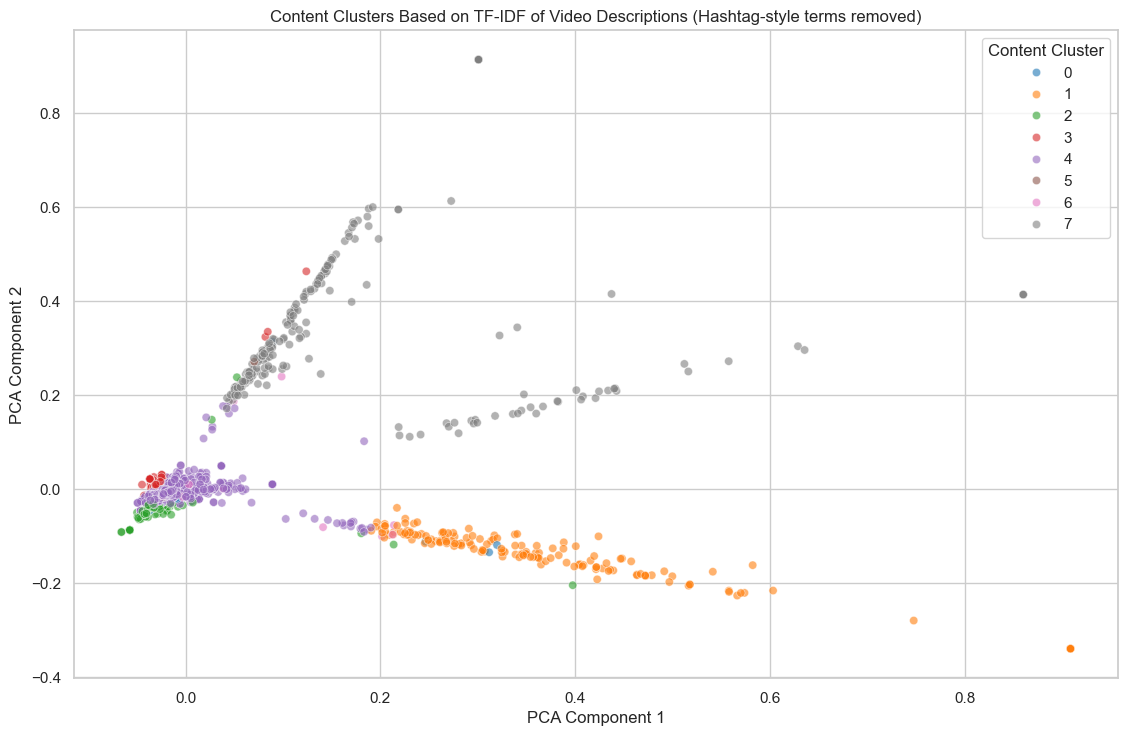


Top terms in each content cluster (based on content descriptions):

Topic 0: graduation, classof, graduate
Size: 87 videos (1.40%)
Top terms: graduation, classof, graduate, grad, senior, highschool, graduated, college, school, graduates
Sample content descriptions:
  - finally drake hibbard graduation highschool highschoolsweethearts...
  - least let her finish partially graduation graduated onlineschool...
  - cant believe graduated are literally covered head toe our graduation gowns and cords theres lit nothing see heidi...

Topic 1: relatable, real, jesuslovesyou
Size: 178 videos (2.86%)
Top terms: relatable, real, jesuslovesyou, blowthisup, help, school, relationship, makemefamous, couple, secretaccount
Sample content descriptions:
  - please help get relatable repost...
  - idc what anyone says the sun clears acne day relatable tan skincare girlhood selfcare real...
  - real uno dog goviral relatable views...

Topic 2: love, relationship, indialove
Size: 158 videos (2.54%)
Top te

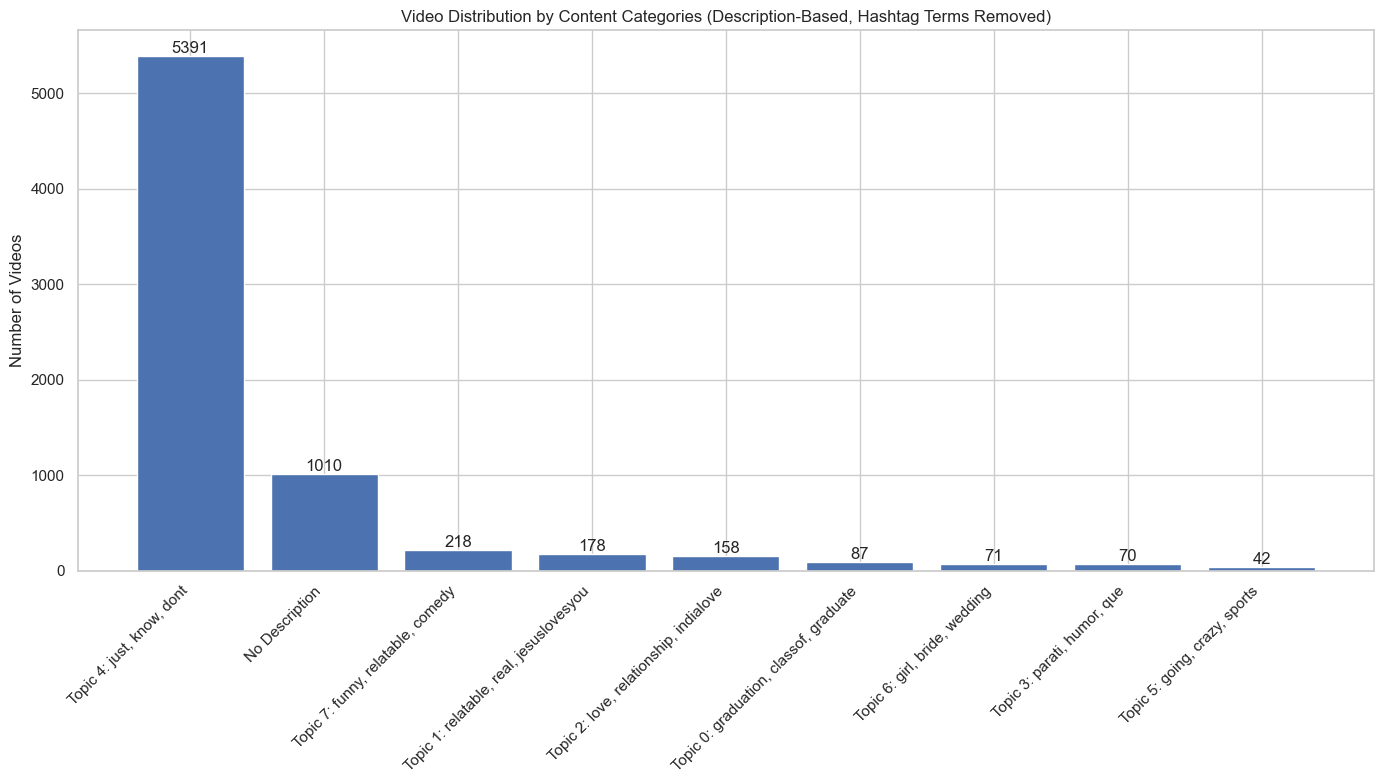

In [5]:
# Use KMeans clustering to identify content-based categories from content descriptions
try:
    # Apply KMeans to TF-IDF features from content descriptions
    # We'll create 8 clusters which will become our content categories
    kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
    kmeans.fit(tfidf_matrix)
    
    # Assign cluster labels to videos with descriptions
    df_with_desc['content_cluster'] = kmeans.labels_
    
    # Visualize the clusters with PCA for dimensionality reduction
    pca = PCA(n_components=2, random_state=42)
    coords = pca.fit_transform(tfidf_matrix.toarray())
    
    # Create a DataFrame for visualization
    cluster_df = pd.DataFrame({
        'x': coords[:, 0],
        'y': coords[:, 1],
        'cluster': kmeans.labels_
    })
    
    # Plot the clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=cluster_df, x='x', y='y', hue='cluster', palette='tab10', alpha=0.6)
    plt.title('Content Clusters Based on TF-IDF of Video Descriptions (Hashtag-style terms removed)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Content Cluster')
    plt.show()
    
    # For each cluster, find the most common words from content descriptions
    print("\nTop terms in each content cluster (based on content descriptions):")
    cluster_names = {}
    
    for i in range(8):
        cluster_indices = np.where(kmeans.labels_ == i)[0]
        cluster_tfidf = tfidf_matrix[cluster_indices].toarray().sum(axis=0)
        top_term_indices = cluster_tfidf.argsort()[-10:][::-1]
        top_terms = [feature_names[idx] for idx in top_term_indices]
        
        # Create a descriptive name for the cluster based on top terms
        cluster_name = f"Topic {i}: {', '.join(top_terms[:3])}"
        cluster_names[i] = cluster_name
        
        print(f"\n{cluster_name}")
        print(f"Size: {len(cluster_indices)} videos ({len(cluster_indices)/len(df_with_desc)*100:.2f}%)")
        print(f"Top terms: {', '.join(top_terms)}")
        
        # Show sample content descriptions from this cluster
        sample_indices = cluster_indices[:3]  # First 3 videos in cluster
        print("Sample content descriptions:")
        for idx in sample_indices:
            desc = df_with_desc.iloc[idx]['content_description'][:150]
            print(f"  - {desc}...")
    
    # Map cluster numbers to descriptive names
    df_with_desc['content_category'] = df_with_desc['content_cluster'].map(cluster_names)
    
    # Merge back to main dataframe
    df = df.merge(
        df_with_desc[['video_id', 'content_cluster', 'content_category']], 
        on='video_id', 
        how='left'
    )
    
    # Fill missing values for videos without descriptions
    df['content_cluster'] = df['content_cluster'].fillna(-1)
    df['content_category'] = df['content_category'].fillna('No Description')
    
    # Plot distribution of content categories
    plt.figure(figsize=(14, 8))
    category_counts = df['content_category'].value_counts()
    bars = plt.bar(range(len(category_counts)), category_counts.values)
    plt.xticks(range(len(category_counts)), category_counts.index, rotation=45, ha='right')
    plt.title('Video Distribution by Content Categories (Description-Based, Hashtag Terms Removed)')
    plt.ylabel('Number of Videos')
    plt.tight_layout()
    
    # Add count labels to bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height}', ha='center', va='bottom')
    
    plt.show()
    
except Exception as e:
    print(f"Error in clustering: {e}")
    print("Continuing with alternative approach...")

## 3. Engagement Pattern Categorization

Now we'll categorize videos based on their engagement patterns, which can reveal different types of content based on how users interact with it.

Using engagement features: ['engagement_rate_per_play', 'weighted_engagement_rate', 'commenting_rate', 'sharing_rate', 'viral_coefficient']

Engagement pattern cluster centers:


,engagement_rate_per_play,weighted_engagement_rate,commenting_rate,sharing_rate,viral_coefficient,pattern
0,0.257837,0.860541,0.001802,0.066166,0.110795,Viral Sharers
1,0.157905,0.247608,0.001247,0.009413,0.052327,Passive Viewers
2,0.247837,0.451941,0.001538,0.021995,0.085656,Viral Sharers
3,0.071432,0.101784,0.000891,0.002976,0.023096,Passive Viewers
4,0.171222,0.450554,0.036363,0.014875,0.066077,Interactive Content


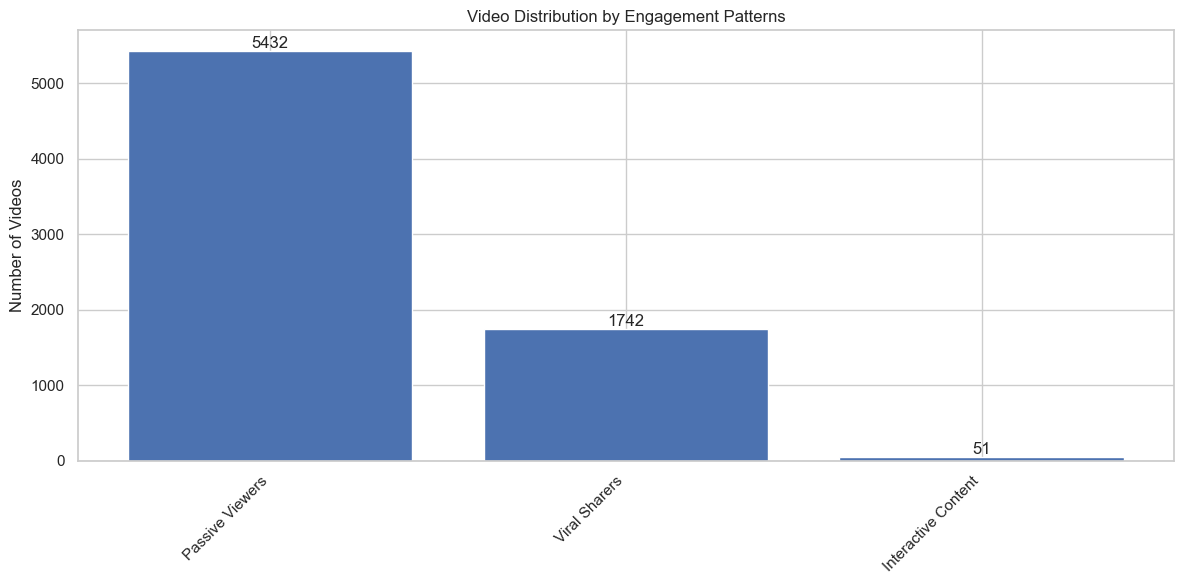

In [6]:
# Select engagement metrics for clustering
engagement_features = [
    'engagement_rate_per_play', 
    'weighted_engagement_rate',
    'commenting_rate',
    'sharing_rate',
    'viral_coefficient'
]

# Check if we have these columns
available_features = [col for col in engagement_features if col in df.columns]
print(f"Using engagement features: {available_features}")

# Create a copy of the dataframe with just the engagement features
engagement_df = df[available_features].copy()

# Handle any remaining nulls with median imputation
for col in engagement_df.columns:
    if engagement_df[col].isna().sum() > 0:
        engagement_df[col] = engagement_df[col].fillna(engagement_df[col].median())

# Scale the features for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
engagement_scaled = scaler.fit_transform(engagement_df)

# Apply KMeans clustering to identify engagement patterns
kmeans_eng = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_eng.fit(engagement_scaled)

# Assign cluster labels to the main DataFrame
df['engagement_cluster'] = kmeans_eng.labels_

# Calculate the mean values for each cluster
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans_eng.cluster_centers_),
    columns=available_features
)

# Get the engagement pattern descriptions
engagement_patterns = {
    0: "Undefined",
    1: "Undefined",
    2: "Undefined",
    3: "Undefined",
    4: "Undefined"
}

# Analyze the cluster centers to name the patterns
for i in range(len(cluster_centers)):
    row = cluster_centers.iloc[i]
    
    # Check which metrics are highest for this cluster
    if row['viral_coefficient'] > cluster_centers['viral_coefficient'].median():
        if row['sharing_rate'] > cluster_centers['sharing_rate'].median():
            engagement_patterns[i] = "Viral Sharers"
        elif row['commenting_rate'] > cluster_centers['commenting_rate'].median():
            engagement_patterns[i] = "Community Engagers"
        else:
            engagement_patterns[i] = "Balanced Performers"
    elif row['commenting_rate'] > cluster_centers['commenting_rate'].median():
        if row['sharing_rate'] < cluster_centers['sharing_rate'].median():
            engagement_patterns[i] = "Comment Drivers"
        else:
            engagement_patterns[i] = "Interactive Content"
    elif row['engagement_rate_per_play'] < cluster_centers['engagement_rate_per_play'].median():
        engagement_patterns[i] = "Passive Viewers"
    else:
        engagement_patterns[i] = "Average Performers"

# Map engagement clusters to pattern names
df['engagement_pattern'] = df['engagement_cluster'].map(engagement_patterns)

# Display the cluster centers and pattern names
cluster_centers['pattern'] = [engagement_patterns[i] for i in range(len(cluster_centers))]
print("\nEngagement pattern cluster centers:")
display(cluster_centers)

# Visualize the distribution of engagement patterns
plt.figure(figsize=(12, 6))
pattern_counts = df['engagement_pattern'].value_counts()
bars = plt.bar(pattern_counts.index, pattern_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Video Distribution by Engagement Patterns')
plt.ylabel('Number of Videos')
plt.tight_layout()

# Add count labels to bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height}', ha='center', va='bottom')

plt.show()

## 4. Combining Categories for Comprehensive Analysis

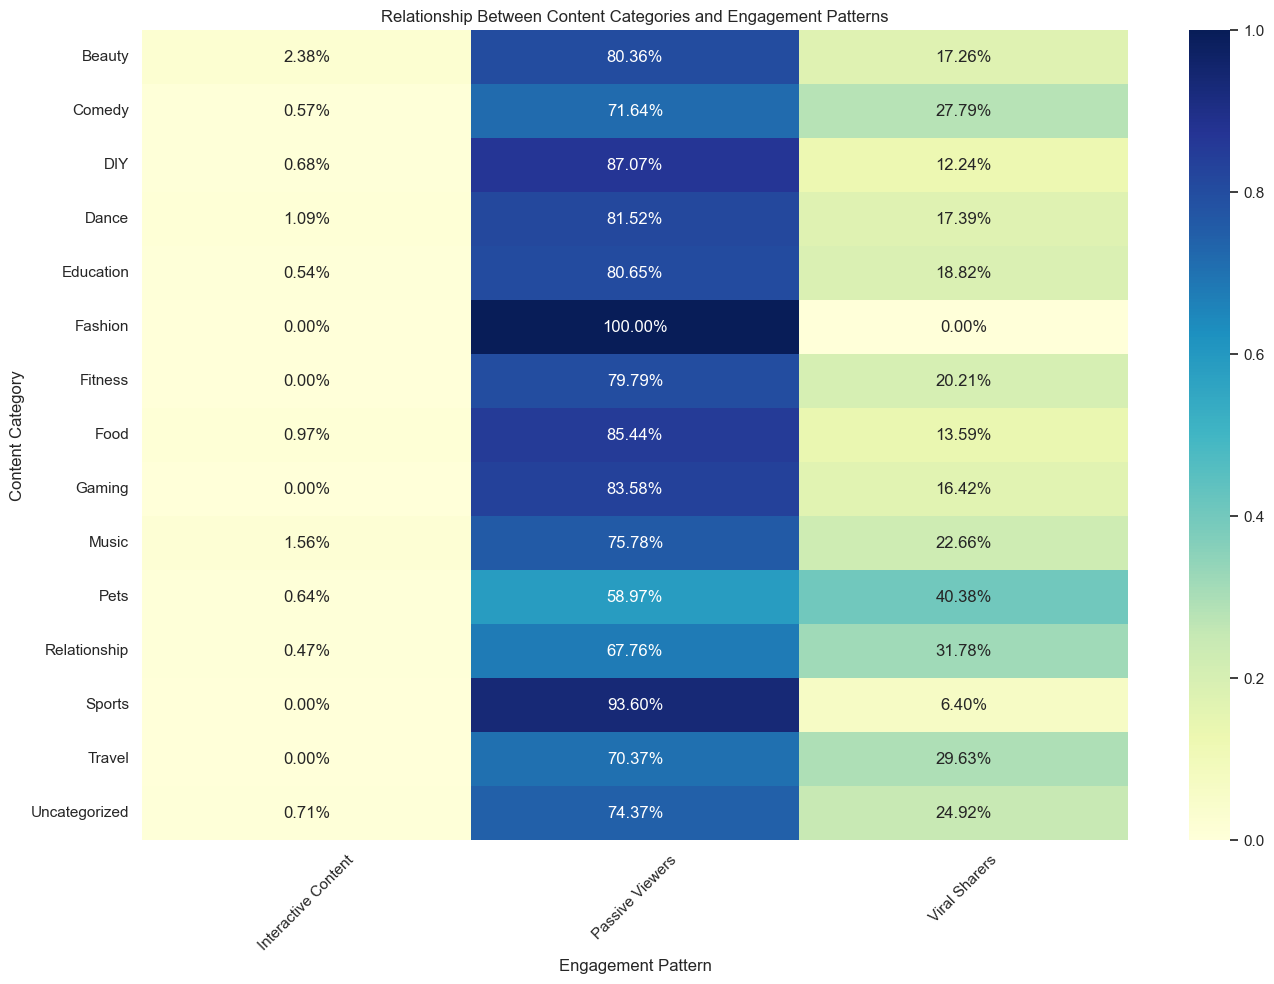


Average engagement metrics by hashtag category:


,engagement_rate_per_play,viral_coefficient
primary_hashtag_category,,
Pets,0.172330,0.060321
Relationship,0.161203,0.056711
Comedy,0.146088,0.052736
Travel,0.147598,0.051947
Uncategorized,0.145881,0.050200
Music,0.153219,0.050178
Dance,0.145329,0.048439
Education,0.136719,0.046284
Beauty,0.139839,0.045661


<Figure size 1400x800 with 0 Axes>

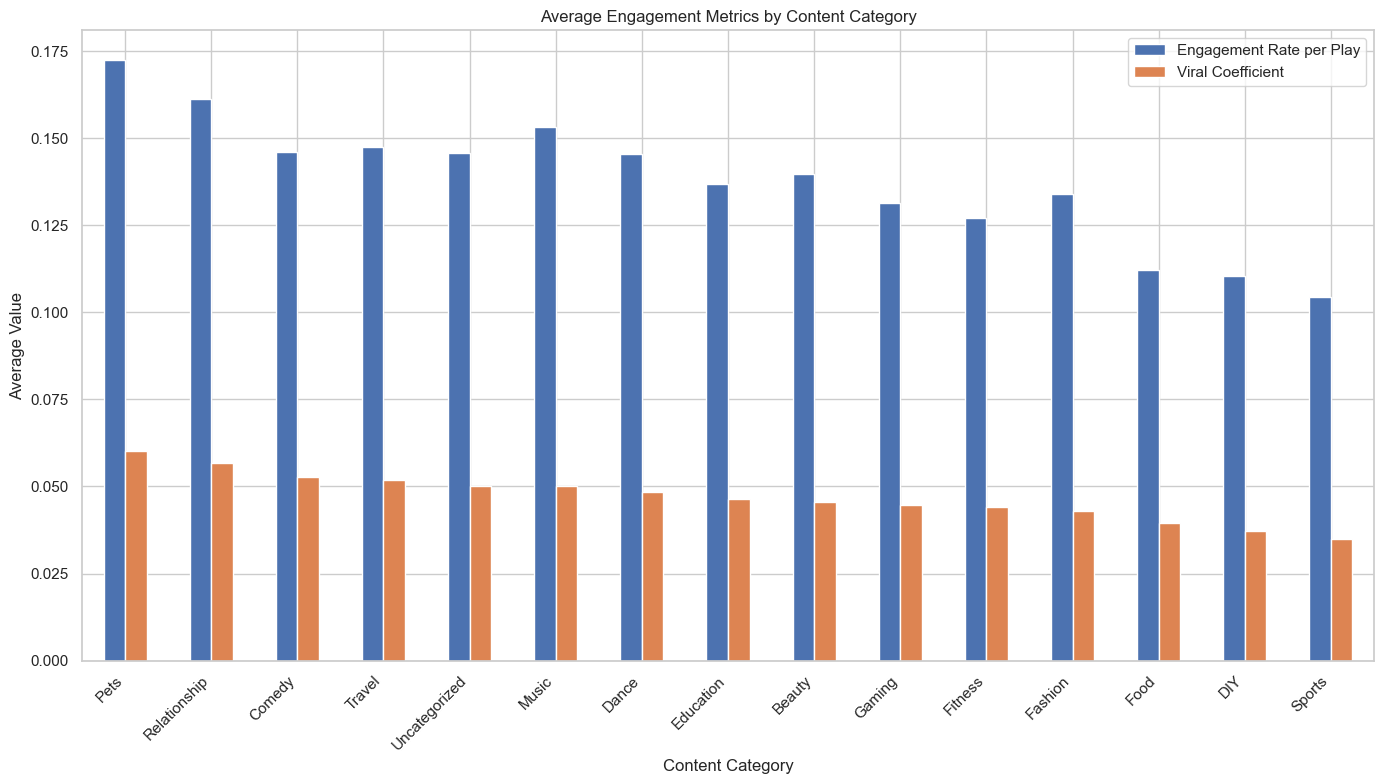


Top category and engagement pattern combinations:


,primary_hashtag_category,engagement_pattern,video_count,plays,likes,comments,shares,viral_coefficient,engagement_rate_per_play
37,Uncategorized,Passive Viewers,3748,2.143268e+06,192508.550694,1716.428762,12348.729989,0.036208,0.110525
38,Uncategorized,Viral Sharers,1256,1.483826e+06,290632.643312,2079.654459,56146.095541,0.091599,0.250917
4,Comedy,Passive Viewers,379,2.342161e+06,206977.857520,1705.039578,24215.696570,0.037649,0.110469
32,Sports,Passive Viewers,190,1.666059e+06,119393.731579,1200.578947,4906.589474,0.030700,0.094782
13,Education,Passive Viewers,150,1.341311e+06,126326.713333,1434.960000,10147.020000,0.034497,0.103523
5,Comedy,Viral Sharers,147,1.576518e+06,262396.598639,1885.959184,67101.959184,0.091271,0.236895
30,Relationship,Passive Viewers,145,1.489714e+06,162531.034483,1206.358621,9729.765517,0.038976,0.118711
1,Beauty,Passive Viewers,135,2.326956e+06,257182.962963,1523.696296,10185.703704,0.036492,0.114847
7,DIY,Passive Viewers,128,2.143823e+06,126521.093750,1104.507812,9592.218750,0.029755,0.089789
24,Music,Passive Viewers,97,1.466849e+06,147591.711340,1015.422680,5214.237113,0.037560,0.117924


In [7]:
# Create cross-tabulation between hashtag categories and engagement patterns
# For simplicity, we'll use the primary hashtag category for each video
df['primary_hashtag_category'] = df['hashtag_categories'].apply(
    lambda x: x[0] if x and x[0] != 'Uncategorized' else ('Uncategorized' if 'Uncategorized' in x else 'Other')
)

# Create cross-tabulation
hashtag_engagement_crosstab = pd.crosstab(
    df['primary_hashtag_category'], 
    df['engagement_pattern'],
    normalize='index'  # Normalize by row (hashtag category) to get percentages
)

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(hashtag_engagement_crosstab, annot=True, cmap='YlGnBu', fmt='.2%')
plt.title('Relationship Between Content Categories and Engagement Patterns')
plt.ylabel('Content Category')
plt.xlabel('Engagement Pattern')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate average engagement metrics for each hashtag category
category_engagement = df.groupby('primary_hashtag_category')[
    ['engagement_rate_per_play', 'viral_coefficient']
].mean().sort_values('viral_coefficient', ascending=False)

# Display average engagement by category
print("\nAverage engagement metrics by hashtag category:")
display(category_engagement)

# Plot the engagement metrics by hashtag category
plt.figure(figsize=(14, 8))
category_engagement.plot(kind='bar', figsize=(14, 8))
plt.title('Average Engagement Metrics by Content Category')
plt.ylabel('Average Value')
plt.xlabel('Content Category')
plt.xticks(rotation=45, ha='right')
plt.legend(['Engagement Rate per Play', 'Viral Coefficient'])
plt.tight_layout()
plt.show()

# Create a summary DataFrame that includes category, engagement pattern, and key metrics
summary_df = df.groupby(['primary_hashtag_category', 'engagement_pattern']).agg({
    'video_id': 'count',
    'plays': 'mean',
    'likes': 'mean',
    'comments': 'mean',
    'shares': 'mean',
    'viral_coefficient': 'mean',
    'engagement_rate_per_play': 'mean'
}).reset_index()

summary_df = summary_df.rename(columns={'video_id': 'video_count'})

# Sort by video count to see the most common combinations
summary_df = summary_df.sort_values('video_count', ascending=False)

print("\nTop category and engagement pattern combinations:")
display(summary_df.head(15))

## 5. Creating a Unified Category System

- unified categorization system that considers both content and engagement patterns

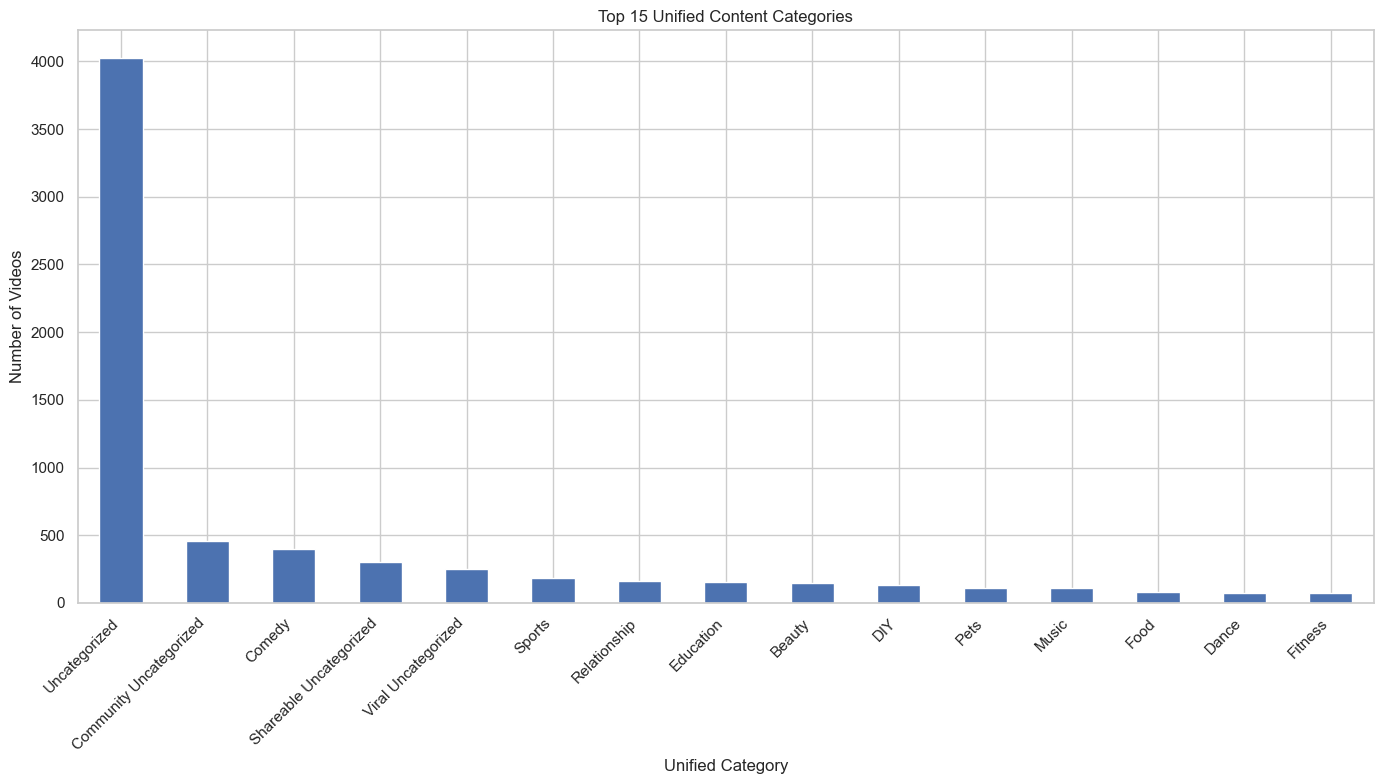

Saved categorized data to data/processed/tiktok_categorized.csv

Unified Category Statistics:


,plays,likes,comments,shares,viral_coefficient,engagement_rate_per_play,count
unified_category,,,,,,,
Uncategorized,2.100982e+06,214984.567917,1261.495406,14285.395332,0.043193,0.131780,4027
Community Uncategorized,1.111634e+06,137214.954248,8539.152505,14893.100218,0.052503,0.148646,459
Comedy,2.264898e+06,215828.378109,1291.860697,25163.776119,0.043284,0.127253,402
Shareable Uncategorized,2.032994e+06,269450.331126,1892.215232,95559.622517,0.079846,0.186739,302
Viral Uncategorized,1.377973e+06,318936.111111,2873.654762,95937.857143,0.122461,0.317223,252
Sports,1.691377e+06,122077.478261,909.206522,5016.728261,0.031614,0.097719,184
Relationship,1.479980e+06,181674.842767,1026.427673,11330.861635,0.046279,0.140867,159
Education,1.322738e+06,141814.506579,911.460526,10357.822368,0.040828,0.123563,152
Beauty,2.275132e+06,279158.108108,1371.371622,11637.527027,0.042377,0.133090,148


In [8]:
# Create a function to assign a unified category
def assign_unified_category(row):
    # Extract primary elements
    category = row['primary_hashtag_category']
    engagement = row['engagement_pattern']
    
    # Special cases for highly viral content
    if row['viral_coefficient'] > df['viral_coefficient'].quantile(0.95):
        return f"Viral {category}"
    
    # Community content with high comment rates
    if row['commenting_rate'] > df['commenting_rate'].quantile(0.9):
        return f"Community {category}"
    
    # Content that gets shared a lot
    if row['sharing_rate'] > df['sharing_rate'].quantile(0.9):
        return f"Shareable {category}"
        
    # Default case - just use the primary content category
    return category

# Apply the unified category function
df['unified_category'] = df.apply(assign_unified_category, axis=1)

# Count videos in each unified category
unified_counts = df['unified_category'].value_counts()

# Display top unified categories
plt.figure(figsize=(14, 8))
unified_counts.head(15).plot(kind='bar')
plt.title('Top 15 Unified Content Categories')
plt.ylabel('Number of Videos')
plt.xlabel('Unified Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Save the categorized data to a new file
output_path = 'data/processed/tiktok_categorized.csv'
df.to_csv(output_path, index=False)
print(f"Saved categorized data to {output_path}")

# Display statistics about the unified categories
print("\nUnified Category Statistics:")
display(df.groupby('unified_category').agg({
    'plays': 'mean',
    'likes': 'mean',
    'comments': 'mean',
    'shares': 'mean',
    'viral_coefficient': 'mean',
    'engagement_rate_per_play': 'mean',
    'video_id': 'count'
}).sort_values('video_id', ascending=False).rename(columns={'video_id': 'count'}).head(10))

## Conclusion

Three different categorization systems for TikTok videos:

1. **Hashtag-based categories**: Grouped videos by common themes in hashtags
2. **Content-based categories**: Used NLP to identify topics from video descriptions only
3. **Engagement pattern categories**: Clustered videos based on user interaction patterns

Unified categorization system that considers both content type and engagement patterns.

## How This Categorization Enables Comprehensive EDA

These categories are  for our Exploratory Data Analysis (EDA) that will help identify key drivers of virality:

### 1. **Category-Based Trend Analysis**
- **Pattern Discovery**: Compare engagement rates, viral coefficients, and growth patterns across different content categories
- **Content Performance**: Identify which types of content (Dance, Comedy, Beauty, etc.) consistently perform better
- **Audience Preferences**: Understand what content resonates most with TikTok audiences

### 2. **Time-Based Trend Visualization**
- **Category Evolution**: Track how different content categories rise and fall over time
- **Seasonal Patterns**: Identify if certain categories (e.g., Fitness, Travel) have seasonal trends
- **Viral Lifecycles**: Analyze how long different types of content stay trending

### 3. **Engagement Pattern Insights**
- **Virality Drivers**: Compare which engagement patterns (Comment Drivers, Viral Sharers, etc.) lead to higher viral coefficients
- **Content-Engagement Correlation**: Understand how content type relates to user interaction behavior
- **Optimization Strategies**: Identify optimal engagement patterns for different content categories

### 4. **Cross-Category Analysis**
- **Content Hybridization**: Analyze videos that belong to multiple categories and their performance
- **Niche vs Broad Appeal**: Compare performance of specialized vs general content
- **Category Combinations**: Identify successful content category combinations

### 5. **Sentiment Analysis Enhancement**
- **Category-Specific Sentiment**: Analyze sentiment patterns within each content category
- **Sentiment-Performance Correlation**: Correlate sentiment scores with engagement patterns and virality
- **Content-Sentiment Optimization**: Identify optimal sentiment approaches for different content types

### Next Steps for EDA
- Create comprehensive dashboards showing category performance over time
- Build predictive models for content virality based on category and engagement patterns
- Perform deep-dive analysis into top-performing categories
- Identify emerging content trends and category shifts
- Develop content strategy recommendations based on data-driven insights